# Лабораторная работа

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Баллы за секции:
- *Задание 1* - 10 баллов
- *Задание 2* - 20 баллов
- *Задание 3* - 30 баллов
- **Итого** - 60 баллов

Оценка за лабу $ = \frac{score}{6}$

## Внимание! Attention! Achtung!

**Данная лабораторная работа является блокирующей**, т.е. если лабораторная работа не выполнена, то оценка за курс - неуд.

Лабораторная работа считается выполненной, если **за каждое из заданий получено не менее 2 баллов**.

## Формат сдачи лабораторной работы

Данная лабораторная работа сдается так же, как и проект - заполняете данный ноутбук, отправляете его через GitHub с указанием проверяющего.

**Ассистенты не будут запускать ячейки кода, а смотреть на выведенный результат и код. Если ячейка кода не запущена - балл не ставится, даже при правильно написанном коде.**

***(Комментарии что курс по Python легче чем по C++ учтены)***

>**Примечание**
>
>Данные задания вдохновлены предметом "Введение в анализ данных" 2 курса, по итогу которого идёт отбор на DS-поток. Если вы видите себя в смежных областях, советуем выполнить данную лабораторку по максимуму.

In [16]:
# Всё необходимое для выполнения данной лабораторной работы!
import requests
from time import sleep

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Задание 1. Парсинг - 10 баллов

В этом задании Вам предстоит работать с API сайта <a target="_blank" href="hh.ru">hh.ru</a>. Документация доступна по <a target="_blank" href="https://github.com/hhru/api/blob/master/docs/vacancies.md#search">ссылке</a>.

<b><font color="red">Внимание!</font> При работе с API не забывайте делать паузы между запросами, иначе вас забанят. Просрочка дедлайна по этой причине не принимается!</b>

**Задача:**
1. выбрать 5 интересующих вас профессий (не смежных, т.е. Аналатик и Data Engineer не считается корректным)
2. затем получить доступные по данным профессиям вакансии в Москве и выделить их физические координаты
3. нанести полученные координаты на карту местоположения компаний

*Пример запроса для профессии:*

In [ ]:
URL = 'https://api.hh.ru/vacancies'

params = {
    'text': "Банщик",
    'area': 1,
    'page': 0,
    'per_page': 10,
    'city': "Москва"
}

data = requests.get(URL, params).json()

sleep(0.2)

In [ ]:
data['items'][0]['address']['lng']

37.659452

Если Ваш запрос прошел успешно, то вы получите следующие ключи (значения данных ключей вы найдете по ссылке на документацию):

In [ ]:
data.keys()

dict_keys(['items', 'found', 'pages', 'page', 'per_page', 'clusters', 'arguments', 'fixes', 'suggests', 'alternate_url'])

>**Примечание**
>
>В `data['pages']` будет хранится количество найденных страниц вакансий - для корректного сбора данных Вам нужно пробежать по **КАЖДОЙ** странице и сделать соотвествующие запросы.

>**Совет**
>
>Посмотрите что хранится в `items`!

(1 балл) Выберете для нас 5 наиболее интересных специальностей и получите по ним имеющиеся вакансии:

In [ ]:
params_array = [
    {
        'text': "Банщик",
        'area': 1,
        'page': 0,
        'per_page': 50
    },
    {
        'text': "Сварщик",
        'area': 1,
        'page': 0,
        'per_page': 50
    },
    {
        'text': "Грузчик",
        'area': 1,
        'page': 0,
        'per_page': 50
    },
    {
        'text': "Backend-разработчик C++",
        'area': 1,
        'page': 0,
        'per_page': 50
    },
    {
        'text': "Аналитик",
        'area': 1,
        'page': 0,
        'per_page': 50
    }
]

data_array = [list() for _ in range(5)]

for i in range(5):
    pages_count = requests.get(URL, params_array[i]).json()['pages']
    sleep(0.3)
    for j in range(pages_count):
        params_array[i]['page'] = j
        data_array[i] += requests.get(URL, params_array[i]).json()['items']
        sleep(0.3)

(1 балл) Посчитайте сколько всего найдено вакансий:

In [ ]:
sum = 0
for req in data_array:
    sum += len(req)
print(sum)

4688


(1 балл) Создайте структуру данных, которая будет хранить в себе имя компании и ее координаты (широта и долгота):

In [ ]:
class Company:
    def __init__(self, name, lat, lng):
        self.name = name
        self.lat = lat
        self.lng = lng

(1 балл) Создайте экземпляр этой структуры данных для каждой компании, которая выставила вакансию:

In [ ]:
companies = set()

for req in data_array:
    for vac in req:
        if vac['address'] and vac['address']['lat'] and vac['address']['lng']:
            companies.add(Company(vac['employer']['name'], vac['address']['lat'], vac['address']['lng']))
        else:
            companies.add(Company(vac['employer']['name'], 0, 0))

(1 балл) Найдите количество вакансий, у которых заданы координаты (значения данных может быть пустым):

In [ ]:
sum = 0

for req in data_array:
    for vac in req:
        if vac['address'] and vac['address']['lat'] and vac['address']['lng']:
            sum += 1

print(sum)

2767


(1 балл) Отберите вакансии, которые расположены в пределах МКАД (можно грубо):

In [ ]:
up = 55.9110186
down = 55.5718374
right = 37.8402381
left = 37.3690805

companies_msk = list()
coords = {"x": list(), "y": list()}
for req in data_array:
    for vac in req:
        if vac['address'] and vac['address']['lat'] and up >= vac['address']['lat'] and down <= vac['address']['lat'] and right >= vac['address']['lng'] and left <= vac['address']['lng']:
            companies_msk.append(vac)
            coords['x'].append(vac['address']['lat'])
            coords['y'].append(vac['address']['lng'])

(1 балл) Постройте график в координатах "широта-долгота" для отображения вакансий внутри МКАД (не забывайте прописать прозрачность, чтобы увидеть скопления):

<Axes: xlabel='x', ylabel='y'>

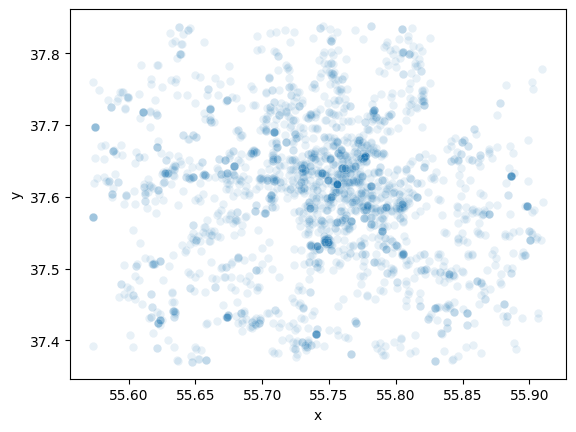

In [ ]:
sns.scatterplot(data=coords, x='x', y='y', alpha=0.1)

(1 балл) Нанесите все точки вакансий на карту (для этого вам поможет данная <a target="_blank" href="https://plotly.com/python/mapbox-layers/">документации</a>, не забудьте про прозрачность и центрирование по Москве):

In [ ]:
import plotly.express as px

coord_in_msk = list()
for vac in companies_msk:
    if isinstance(vac['salary'], dict):
        coord_in_msk.append({'lat': vac['address']['lat'], 'lng': vac['address']['lng'], 'name': vac['professional_roles'][0]['name'], 'sal': vac['salary']['from']})
    elif isinstance(vac['salary'], int):
        coord_in_msk.append({'lat': vac['address']['lat'], 'lng': vac['address']['lng'], 'name': vac['professional_roles'][0]['name'], 'sal': vac['salary']})
    else:
        coord_in_msk.append({'lat': vac['address']['lat'], 'lng': vac['address']['lng'], 'name': vac['professional_roles'][0]['name'], 'sal': 'None'})

fig = px.scatter_mapbox(coord_in_msk, lat='lat', lon='lng',  hover_name="name", hover_data=['sal'],
                        zoom=10, height=700, center={'lat': 55.75330, 'lon': 37.6230})
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

(2 балла) **Сделайте выводы о проделанной работе:**

>*Подсказки для маленьких: Что вы можете сказать про районы Москвы? Что вы можете сказать про зарплаты? Что вы можете сказать про спрос?*

Выводы о проделонной работе такие:
  1) Внутри садового кольца большой популярностью служит професиия банщик-массажист. Разработчики тоже очень нужны, как и аналитики.
  2) Между садовым кольцом и 3 транспортным кольцом в основном нужны грузчики, но уже больше вакансий появляется для аналитиков, тестировщиков и разработчиков.
  3) В деловом центре ситуация такая: нужны грузчики, сварщики и аналитики.
  4) В востосточном округе больше всего вакансий на работу сварщика. Есть и для грузчиков и программистов работа.
  5) Самая близкая вакансия к мфти - кладовщик.

Самая большая средняя зарплата у сварщиков - мода = 120000. У грузчика средняя зарплата 60000, у аналитиков и разработчиков 80000. У банщика стоимость оплаты труда сильно зависит от района - в центре это 130000, за пределами садового кольца 60-80к.

Обший вывод: в Москве больше востребована работа руками, аналитики и разработчики не так сильно востребованы. Банщик-массажист тоже хорошая профессия, востребованная в центре Москвы. Менеджеры и дизайнеры тоже требуются.

## Задание 2. Анализ данных - 20 баллов

Вам предстоит проанализировать датасет, содержащий информацию об бриллианта, их стоимости и остальных характеристиках.



Поясним значения хранящиеся в колонках:
*   `cut` - огранка бриллианта (относится к одной из примерно 10 наиболее распространенных)
*   `color` - цвет бриллианта, прозрачные бриллианты имеют градацию `D-Z`, "более высокие" буквы - более желтоватые, но часто имеют лучшие значения, поскольку цвет трудно определить один раз в кольце
*   `clarity` - чистота бриллианта, наличие включений (внутренних дефектов), чем меньше и мельче, тем лучше
*   `carat_weight` - масса бриллианта (слабо связана с размером бриллианта, т.к. огранка и качество огранки, как правило, играют большую роль)
*   `cut_quality` - качество ограники по системе оценки GIA Cut
*   `lab` - лаборатория оценивания
*   `meas_length` - длина бриллианта
*   `meas_width` - ширина бриллианта
*   `meas_depth` - глубина бриллианта
*   `total_sales_price` - цена бриллианта в долларах.
*    **и прочие колонки**

Скачаем данные:

In [1]:
!gdown 10OJ30qlkE-7zK4JuVTDMY3U4nRB4tu_8

Downloading...
From: https://drive.google.com/uc?id=10OJ30qlkE-7zK4JuVTDMY3U4nRB4tu_8
To: /content/diamonds.csv
100% 35.4M/35.4M [00:00<00:00, 113MB/s]


Создадим DataFrame:

In [ ]:
import pandas as pd

diamonds = pd.read_csv("diamonds.csv")
diamonds

,Unnamed: 0,cut,color,clarity,carat_weight,cut_quality,lab,symmetry,polish,eye_clean,...,meas_depth,girdle_min,girdle_max,fluor_color,fluor_intensity,fancy_color_dominant_color,fancy_color_secondary_color,fancy_color_overtone,fancy_color_intensity,total_sales_price
0,0,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,...,1.79,M,M,unknown,NaN,unknown,unknown,unknown,unknown,200
1,1,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,unknown,...,1.78,STK,STK,unknown,NaN,unknown,unknown,unknown,unknown,200
2,2,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,...,1.77,TN,M,unknown,NaN,unknown,unknown,unknown,unknown,200
3,3,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,...,1.78,M,STK,unknown,NaN,unknown,unknown,unknown,unknown,200
4,4,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Excellent,unknown,...,1.82,STK,STK,unknown,NaN,unknown,unknown,unknown,unknown,200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219698,219699,Round,E,VS1,10.65,Excellent,GIA,Excellent,Excellent,unknown,...,8.66,M,STK,unknown,NaN,unknown,unknown,unknown,unknown,1210692
219699,219700,Radiant,unknown,VS2,5.17,unknown,GIA,Very Good,Very Good,unknown,...,5.71,TK,XTK,unknown,NaN,Green,unknown,NaN,Fancy Light,1292500
219700,219701,Round,E,VS1,18.07,Excellent,GIA,Excellent,Excellent,unknown,...,10.20,TN,M,unknown,NaN,unknown,unknown,unknown,unknown,1315496
219701,219702,Princess,unknown,SI2,0.90,unknown,GIA,Good,Good,unknown,...,3.47,XTN,VTK,unknown,Faint,Red,unknown,unknown,Fancy,1350000


(0.5 балла) Выведете первые 5 строк датасета:

In [2]:
import pandas as pd

diamonds = pd.read_csv("diamonds.csv")
diamonds.head()

,Unnamed: 0,cut,color,clarity,carat_weight,cut_quality,lab,symmetry,polish,eye_clean,...,meas_depth,girdle_min,girdle_max,fluor_color,fluor_intensity,fancy_color_dominant_color,fancy_color_secondary_color,fancy_color_overtone,fancy_color_intensity,total_sales_price
0,0,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,...,1.79,M,M,unknown,NaN,unknown,unknown,unknown,unknown,200
1,1,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,unknown,...,1.78,STK,STK,unknown,NaN,unknown,unknown,unknown,unknown,200
2,2,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,...,1.77,TN,M,unknown,NaN,unknown,unknown,unknown,unknown,200
3,3,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,...,1.78,M,STK,unknown,NaN,unknown,unknown,unknown,unknown,200
4,4,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Excellent,unknown,...,1.82,STK,STK,unknown,NaN,unknown,unknown,unknown,unknown,200


(0.5 балла) Найдите количество бриллиантов всего в данном датасете:

In [3]:
diamonds.count()['cut']

219703

(0.5 балла) Выведите максимальную и минимальную цену бриллианта в формате `номер - цена`:

In [4]:
print(str(diamonds['total_sales_price'].idxmax()) + ' - ' + str(diamonds['total_sales_price'].max()))
print(str(diamonds['total_sales_price'].idxmin()) + ' - ' + str(diamonds['total_sales_price'].min()))

219702 - 1449881
0 - 200


(1 балл) Посчитайте количество пропусков (пропуском считается значение `unknown` или `None`):

In [5]:
sum = 0

for index, row in diamonds.iterrows():
    for elem in row:
        if elem == 'unknown' or elem == None:
            sum += 1

sum

1746027

(1 балл) Найдите в каких столбцах присутствуют пропуски:

In [6]:
for column in diamonds.keys():
    for elem in diamonds[column]:
        if elem == 'unknown' or elem == None:
            print(column)
            break

color
cut_quality
eye_clean
culet_size
culet_condition
girdle_min
girdle_max
fluor_color
fluor_intensity
fancy_color_dominant_color
fancy_color_secondary_color
fancy_color_overtone
fancy_color_intensity


В нашем датасете присутствуют колонки, которые начинаются с `fancy_color_` или `fluor_`. Большинство значений в этих колонках - `unknown` или `None`, поэтому мы считаем их малоинформативными.

Ваша задача:

1. (0.5 балла) найти количество таких колонок, которые начинаются с `fancy_color_` или `fluor_`:

In [7]:
count = 0

for column in diamonds.keys():
    if (len(column) >= 12 and column[0:12] == 'fancy_color_') or (len(column) >= 6 and column[0:6] == 'fluor_'):
        for elem in diamonds[column]:
            if elem == 'unknown' or elem == None:
                count += 1
                break

count

6

2. (0.5 балла) найти количество информативных (не `None` или `unknown`) значений в этих колонках:

In [8]:
count = 0

for column in diamonds.keys():
    if (len(column) >= 12 and column[0:12] == 'fancy_color_') or (len(column) >= 6 and column[0:6] == 'fluor_'):
        for elem in diamonds[column]:
            if elem != 'unknown' and elem != None:
                count += 1

count

256727

3. (0.5 балла) удалить данные колонки из датасета, сохранив изменения (в дальнейшем работаем измененным датасетом):

In [9]:
for column in diamonds.keys():
    if (len(column) >= 12 and column[0:12] == 'fancy_color_') or (len(column) >= 6 and column[0:6] == 'fluor_'):
        for elem in diamonds[column]:
            if elem == 'unknown' or elem == None:
                diamonds.pop(column)
                break

(1 балл) Проделайте тоже самое для колонок, начинающихся с `culet_`:

In [10]:
count = 0

for column in diamonds.keys():
    if len(column) >= 6 and column[0:6] == 'culet_':
        for elem in diamonds[column]:
            if elem == 'unknown' or elem == None:
                count += 1
                break

print(count)

count = 0

for column in diamonds.keys():
    if len(column) >= 6 and column[0:6] == 'culet_':
        for elem in diamonds[column]:
            if elem != 'unknown' and elem != None:
                count += 1

print(count)

for column in diamonds.keys():
    if len(column) >= 6 and column[0:6] == 'culet_':
        for elem in diamonds[column]:
            if elem == 'unknown' or elem == None:
                diamonds.pop(column)
                break

2
149282


(1 балл) Посчитайте сколько бы стоил (в тысячах долларов) сейф, в котором хранились бы все бриллианты из датасета:

In [11]:
sum = 0

for sale in diamonds['total_sales_price']:
    sum += sale

sum / 1000

1517721.991

Немного необоснованных манипуляций.

(1 балл) Выберите из датасета строки с четными индексами и выведете значения (не меняя нумерацию индексов):

In [12]:
diamonds.loc[diamonds.index % 2 == 0]

,Unnamed: 0,cut,color,clarity,carat_weight,cut_quality,lab,symmetry,polish,eye_clean,depth_percent,table_percent,meas_length,meas_width,meas_depth,girdle_min,girdle_max,total_sales_price
0,0,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,62.7,59.0,2.85,2.87,1.79,M,M,200
2,2,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,61.1,59.0,2.88,2.90,1.77,TN,M,200
4,4,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Excellent,unknown,64.9,58.5,2.79,2.83,1.82,STK,STK,200
6,6,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,unknown,64.0,57.0,2.85,2.88,1.84,STK,STK,200
8,8,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,unknown,63.5,59.5,2.89,2.92,1.85,STK,TK,200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219694,219695,Round,D,IF,12.52,Excellent,HRD,Excellent,Excellent,unknown,62.1,58.0,14.84,14.91,9.24,unknown,unknown,1121792
219696,219697,Oval,H,VS2,18.88,unknown,GIA,Excellent,Excellent,unknown,57.1,55.0,21.34,15.23,8.69,TN,STK,1132347
219698,219699,Round,E,VS1,10.65,Excellent,GIA,Excellent,Excellent,unknown,61.3,58.0,14.06,14.18,8.66,M,STK,1210692
219700,219701,Round,E,VS1,18.07,Excellent,GIA,Excellent,Excellent,unknown,60.2,59.0,17.06,17.10,10.20,TN,M,1315496


(0.5 балла) А теперь с индексами, кратными 6:

In [13]:
diamonds.loc[diamonds.index % 6 == 0]

,Unnamed: 0,cut,color,clarity,carat_weight,cut_quality,lab,symmetry,polish,eye_clean,depth_percent,table_percent,meas_length,meas_width,meas_depth,girdle_min,girdle_max,total_sales_price
0,0,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,62.7,59.0,2.85,2.87,1.79,M,M,200
6,6,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,unknown,64.0,57.0,2.85,2.88,1.84,STK,STK,200
12,12,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,unknown,61.8,58.5,2.85,2.89,1.77,STK,TK,200
18,18,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,61.0,60.0,2.91,2.92,1.78,M,M,200
24,24,Round,L,I1,0.34,Excellent,IGI,Excellent,Excellent,unknown,0.0,0.0,0.00,0.00,0.00,unknown,unknown,204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219678,219679,Round,G,VS1,10.23,Excellent,GIA,Excellent,Excellent,unknown,62.7,55.0,13.82,13.92,8.69,TN,M,859320
219684,219685,Radiant,unknown,I1,0.89,unknown,GIA,Good,Good,unknown,63.8,57.0,6.44,4.96,3.16,TK,VTK,982560
219690,219691,Round,D,VVS2,10.10,Excellent,GIA,Excellent,Excellent,unknown,59.4,59.0,14.07,14.15,8.39,M,STK,1040739
219696,219697,Oval,H,VS2,18.88,unknown,GIA,Excellent,Excellent,unknown,57.1,55.0,21.34,15.23,8.69,TN,STK,1132347


(1 балл) Выберете из датасета только категорильные признаки и выведете датасет:

In [14]:
category_array = list()

for column in diamonds.keys():
    for elem in diamonds[column]:
        if elem != 'unknown' and elem != None:
            if not isinstance(elem, str):
                category_array.append(column)
            break

diamonds.drop(category_array, axis=1)

,cut,color,clarity,cut_quality,lab,symmetry,polish,eye_clean,girdle_min,girdle_max
0,Round,E,VVS2,Excellent,IGI,Very Good,Very Good,unknown,M,M
1,Round,E,VVS2,Very Good,IGI,Very Good,Very Good,unknown,STK,STK
2,Round,E,VVS2,Excellent,IGI,Very Good,Very Good,unknown,TN,M
3,Round,E,VVS2,Excellent,IGI,Very Good,Very Good,unknown,M,STK
4,Round,E,VVS2,Very Good,IGI,Very Good,Excellent,unknown,STK,STK
...,...,...,...,...,...,...,...,...,...,...
219698,Round,E,VS1,Excellent,GIA,Excellent,Excellent,unknown,M,STK
219699,Radiant,unknown,VS2,unknown,GIA,Very Good,Very Good,unknown,TK,XTK
219700,Round,E,VS1,Excellent,GIA,Excellent,Excellent,unknown,TN,M
219701,Princess,unknown,SI2,unknown,GIA,Good,Good,unknown,XTN,VTK


>**Примечание**
>
>Данный датасет можно использовать для задания 3 (с использованием `sklearn`)

(0.5 балла) Выберете столбец с данными о цене бриллиантов и домножите его на тот столбец, только транспонированный, и выведите полученную матрицу:

In [17]:
np.array(diamonds['total_sales_price']).reshape(1, -1) @ np.array(diamonds['total_sales_price']).reshape(1, -1).T

array([[158540672665477]])

### Построение графиков

**Требования к графику:**

1.   График должен быть подписан
2.   Оси должны быть подписаны
3.   Должна быть легенда графика
4.   График должен быть информативным (желательно без сильных выбросов)

**Все надписи на русском языке!**

>**Примечание**
>
>График необходимо строить для очищенных данных - в них не должно быть пропусков по осям, по которым строите график. При этом **не перезатирайте** имеющийся датафрейм!

(2 балла) Постройте график `цвет бриллианта - стоимость`:

[Text(0.5, 1.0, 'Цвет бриллианта - цена'),
 Text(0.5, 0, 'цвет'),
 Text(0, 0.5, 'цена')]

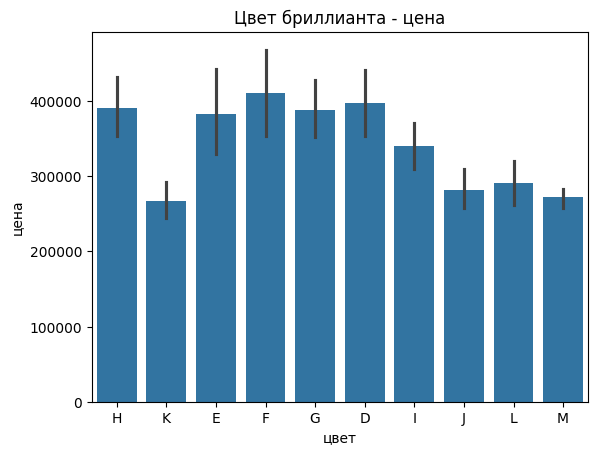

In [18]:
coords = {'color': list(), 'price': list()}

for index, row in diamonds.iterrows():
    if (row['color'] != 'unknown') and (row['color'] != None) and (row['total_sales_price'] != 'unknown') and (row['total_sales_price'] != None) and (row['total_sales_price'] >= 200000):
        coords['color'].append(row['color'])
        coords['price'].append(row['total_sales_price'])

color_price = sns.barplot(data=coords, x='color', y='price')
color_price.set(title='Цвет бриллианта - цена', xlabel='цвет', ylabel='цена')

(2 балла) Постройте график `лабараторная оценка - кол-во бриллиантов`:

[Text(0.5, 1.0, 'Лабораторная оценка - количество'),
 Text(0.5, 0, 'оценка'),
 Text(0, 0.5, 'количество')]

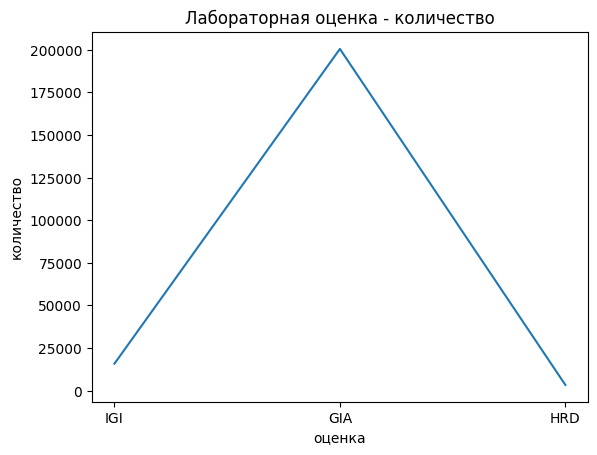

In [19]:
lab_dict = dict()

for elem in diamonds['lab']:
    if elem != 'unknown' and elem != None:
        if elem in lab_dict:
            lab_dict[elem] += 1
        else:
            lab_dict[elem] = 1

coords = {'lab mark': list(), 'count': list()}

for key in lab_dict.keys():
    coords['lab mark'].append(key)
    coords['count'].append(lab_dict[key])

color_price = sns.lineplot(data=coords, x='lab mark', y='count')
color_price.set(title='Лабораторная оценка - количество', xlabel='оценка', ylabel='количество')

(2 балла) Постройте график `вес бриллианта - стоимость`:

[Text(0.5, 1.0, 'Вес бриллианта - цена'),
 Text(0.5, 0, 'вес'),
 Text(0, 0.5, 'цена')]

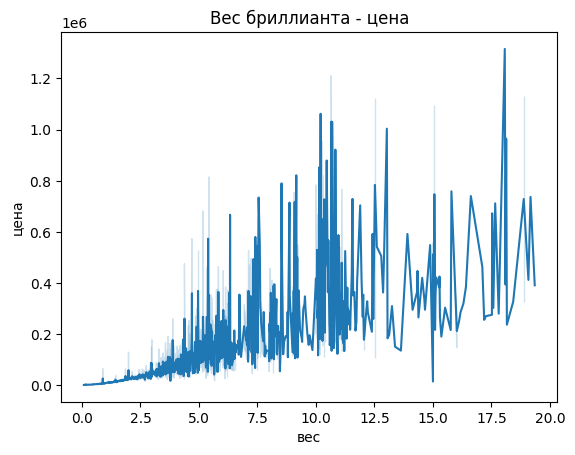

In [20]:
coords = {'weight': list(), 'price': list()}

for index, row in diamonds.iterrows():
    if (row['carat_weight'] != 'unknown') and (row['carat_weight'] != None) and (row['total_sales_price'] != 'unknown') and (row['total_sales_price'] != None):
        coords['weight'].append(row['carat_weight'])
        coords['price'].append(row['total_sales_price'])

color_price = sns.lineplot(data=coords, x='weight', y='price')
color_price.set(title='Вес бриллианта - цена', xlabel='вес', ylabel='цена')

(2 балла) Постройте график `система оценки GIA Cut - кол-во бриллиантов`:

[Text(0.5, 1.0, 'Качество огранки - количество'),
 Text(0.5, 0, 'огранка'),
 Text(0, 0.5, 'количество')]

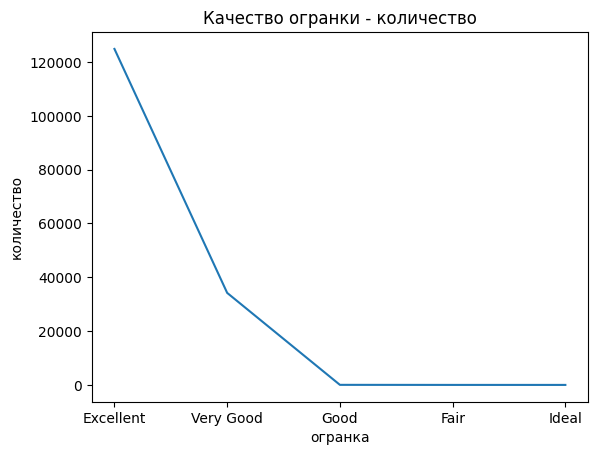

In [21]:
gia_cut_dict = dict()

for elem in diamonds['cut_quality']:
    if elem != 'unknown' and elem != None:
        if elem in gia_cut_dict:
            gia_cut_dict[elem] += 1
        else:
            gia_cut_dict[elem] = 1

coords = {'cut mark': list(), 'count': list()}

for key in gia_cut_dict.keys():
    coords['cut mark'].append(key)
    coords['count'].append(gia_cut_dict[key])

color_price = sns.lineplot(data=coords, x='cut mark', y='count')
color_price.set(title='Качество огранки - количество', xlabel='огранка', ylabel='количество')

(2 балла) **Сделайте выводы по построенным графикам:**

>*Подсказка для маленьких: Что вы можете сказать о графиках полученных выше для данного датасета?*

Цена бриллианта сильно зависит от его веса и цвета. Самый дорогой бриллиант весит около 18 карат. Но в среднем самые дорогие бриллианты в пределах 10-12 карат. Самые дорогие бриллианты имеют цвет - F.
Самая частая оценка огранки - отлично, а вот оценки иделаьно, удовлетворительно и хорошо ставятся очень редко. Иеально всего 1 раз.
Самая частая лабораторная оценка - GIA, остальные оценки выставляются значительно реже.

## Задание 3. Модель - 30 баллов

В данном задании вам предстоит построить классифицирующую модель размер алмаза и его стоимости, а затем оценить полученную модель.

>**Примечание**
>
>Данная модель не претендует на самый верный индикатор стоимости алмаза, ведь мы не учитываем ничего больше чем стоимость алмаза. Исключительно для образовательных целей :)

Для построения модели нам понадобится 4 столбца, а именно:
- `meas_length`
- `meas_width`
- `meas_depth`
- `total_sales_price`

От остальных столбцов можно избавиться.

(1 балл) Создайте новый датасет и выведите его первые 10 строк:

In [22]:
delete_array = list()
for column in diamonds.keys():
    if column != 'meas_length' and column != 'meas_width' and column != 'meas_depth' and column != 'total_sales_price':
        delete_array.append(column)

new_dataset = diamonds.drop(delete_array, axis=1)
new_dataset.loc[new_dataset.index < 10]

,meas_length,meas_width,meas_depth,total_sales_price
0,2.85,2.87,1.79,200
1,2.84,2.89,1.78,200
2,2.88,2.90,1.77,200
3,2.86,2.88,1.78,200
4,2.79,2.83,1.82,200
5,2.95,2.99,1.81,200
6,2.85,2.88,1.84,200
7,2.86,2.89,1.78,200
8,2.89,2.92,1.85,200
9,2.83,2.87,1.80,200


(1 балл) Перемешайте строки в датафрейме случайным образом:

In [23]:
new_dataset = new_dataset.sample(frac=1)
new_dataset.head()

,meas_length,meas_width,meas_depth,total_sales_price
90266,4.93,4.94,3.05,1380
122118,5.33,5.38,3.35,2466
108272,3.81,2.87,2.44,1944
69320,4.13,4.16,2.63,1070
111714,4.41,5.44,3.38,2086


(1 балл) Сформируем новую колонку - для каждого бриллианта найдем сумму Минковского (p=3) по 3 измерениям бриллианта:

In [24]:
new_dataset = new_dataset.assign(minkovskiy_sum = (new_dataset['meas_length']**3 + new_dataset['meas_width']**3 + new_dataset['meas_depth']**3)**(1 / 3))
new_dataset.head()

,meas_length,meas_width,meas_depth,total_sales_price,minkovskiy_sum
90266,4.93,4.94,3.05,1380,6.453311
122118,5.33,5.38,3.35,2466,7.011788
108272,3.81,2.87,2.44,1944,4.538323
69320,4.13,4.16,2.63,1070,5.435926
111714,4.41,5.44,3.38,2086,6.583689


(1 балл) Сформируем новый датасет из двух колонок - сумма Минковского и `total_sales_price`:

In [25]:
two_columns_dataset = new_dataset[['total_sales_price', 'minkovskiy_sum']].copy()
two_columns_dataset.head()

,total_sales_price,minkovskiy_sum
90266,1380,6.453311
122118,2466,7.011788
108272,1944,4.538323
69320,1070,5.435926
111714,2086,6.583689


(1 балл) Разделите вашу выборку на две части в соотношении 8:2 - одна выборка будет для тренировка, а другая для тестов вашей модели:

In [26]:
test_dataset = two_columns_dataset.iloc[:int(two_columns_dataset.count()['total_sales_price'] / 5)]
training_dataset = two_columns_dataset.iloc[int(two_columns_dataset.count()['total_sales_price'] / 5):]
print(test_dataset.count())
print(training_dataset.count())

total_sales_price    43940
minkovskiy_sum       43940
dtype: int64
total_sales_price    175763
minkovskiy_sum       175763
dtype: int64


(2 балла) Постройте график зависимости стоимости от вашего нового параметра размера для тренинг-выборки:

Text(0, 0.5, 'price')

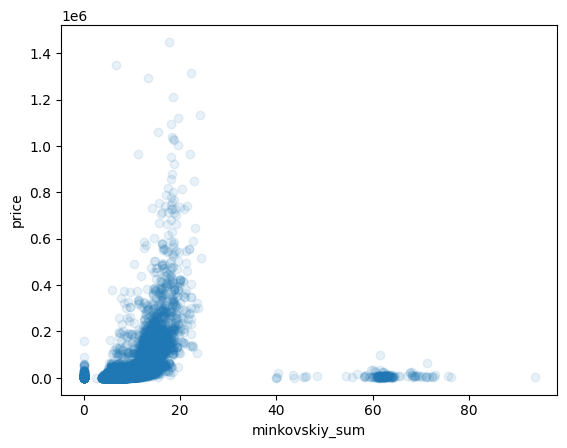

In [27]:
minkov_price = plt.scatter(data=training_dataset, x='minkovskiy_sum', y='total_sales_price', alpha=0.1)
plt.xlabel('minkovskiy_sum')
plt.ylabel('price')

(2 балла) Нанесите на тот же график тестовую выборку, используя другой цвет (не забудьте про параметр прозрачности):

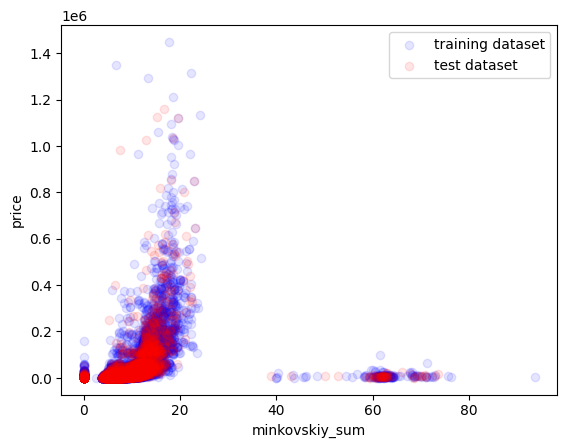

In [28]:
plt.scatter(data=training_dataset, x='minkovskiy_sum', y='total_sales_price', alpha=0.1, color='b')
plt.scatter(data=test_dataset, x='minkovskiy_sum', y='total_sales_price', alpha=0.1, color='r')
plt.xlabel('minkovskiy_sum')
plt.ylabel('price')
plt.legend(('training dataset', 'test dataset'))

(3 балла) Найдите для каждой бриллианта из тестовой выборки его "ближайшего соседа" из тренинг-выборки. Для каждого бриллианта из тестовой выборки найдите расстояния до соответствующего ближайшего соседа:

In [31]:
from sklearn.neighbors import NearestNeighbors

train_minkov = np.array(training_dataset['minkovskiy_sum']).reshape(-1, 1)
train_price = np.array(training_dataset['total_sales_price']).reshape(-1, 1)
test_minkov = np.array(test_dataset['minkovskiy_sum']).reshape(-1, 1)
test_price = np.array(test_dataset['total_sales_price']).reshape(-1, 1)

near_neigh = NearestNeighbors(n_neighbors=1)
near_neigh.fit(train_minkov)

distance_array, index_array = near_neigh.kneighbors(test_minkov)
distance_array

array([[1.56880780e-06],
       [0.00000000e+00],
       [1.31119584e-04],
       ...,
       [1.18196314e-05],
       [0.00000000e+00],
       [1.67757644e-05]])

(3 балла) Найдите насколько сильно (в процентах) отличается цена бриллиантов из тестовой выборки от их соответствующих ближайших соседей:

In [34]:
percent_array = list()

for i in range(len(test_price)):
    if test_price[i] / train_price[index_array[i]] > 1:
        percent_array.append(100 - ((train_price[index_array[i]] / test_price[i]) * 100))
    else:
        percent_array.append(100 - ((test_price[i] / train_price[index_array[i]]) * 100))

for i in range(10):
    print(percent_array[i])

[[35.07246377]]
[[36.2131402]]
[[83.38461538]]
[[0.]]
[[4.50623202]]
[[18.29228511]]
[[48.51973684]]
[[38.71527778]]
[[45.10948905]]
[[21.55963303]]


**Данная модель является выдумкой автора. Не важен коэффициент ошибки, важны ваши шаги для получения коэффициента.**

### Введение в машинное обучение

Теперь давайте познакомимся с таким сильным инструментом как `sklearn`.

Вам необходимо:
1. выбрать 2 категориальных признака
2. на их основе обучить решающее дерево
3. оценить среднеквадратичную ошибку цены бриллианта
4. сделать пп. 1-3 и выбрать ту пару, которая дает лучший результат
5. сделать выводы

(3 балла) Мы работаем с категориальными признаками, для них не понятно что есть "больше" и "меньше". Поэтому нам нужно предварительно закодировать значения наших признаков, с чем нам поможет [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html):

In [48]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore')

delete_array = list()
for column in diamonds:
    if column != 'cut' and column != 'clarity' and column != 'total_sales_price':
        delete_array.append(column)

learn_diamonds = diamonds.drop(delete_array, axis=1)
enc_dataset = pd.DataFrame(enc.fit_transform(learn_diamonds[['cut', 'clarity']]).toarray())

using_dataset = learn_diamonds.join(enc_dataset)
using_dataset = using_dataset.drop(['cut', 'clarity'], axis=1)
using_dataset.head()

,total_sales_price,0,1,2,3,4,5,6,7,8,...,12,13,14,15,16,17,18,19,20,21
0,200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


(3 балла) Разбейте датасет на обучающую и тестовую выбору. Для этого вам поможет [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html):

In [49]:
from sklearn.model_selection import train_test_split

X = using_dataset.drop(['total_sales_price'], axis=1)
y = using_dataset['total_sales_price']

X_train_dataset, X_test_dataset, y_train_dataset, y_test_dataset = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train_dataset.head())
print(X_test_dataset.head())
print(y_train_dataset.head())
print(y_test_dataset.head())

         0    1    2    3    4    5    6    7    8    9   ...   12   13   14  \
34255   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
33445   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
100701  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...  0.0  0.0  0.0   
158452  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
105041  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   

         15   16   17   18   19   20   21  
34255   0.0  0.0  0.0  0.0  0.0  0.0  1.0  
33445   0.0  0.0  0.0  0.0  0.0  1.0  0.0  
100701  0.0  0.0  0.0  0.0  0.0  0.0  1.0  
158452  0.0  0.0  0.0  0.0  0.0  1.0  0.0  
105041  0.0  0.0  0.0  1.0  0.0  0.0  0.0  

[5 rows x 22 columns]
         0    1    2    3    4    5    6    7    8    9   ...   12   13   14  \
167888  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
53087   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0 

(3 балла) Затем создайте и обучите вашу модель - [DecisionTreeRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html):

In [51]:
from sklearn import tree

model = tree.DecisionTreeClassifier()
model = model.fit(X_train_dataset, y_train_dataset)

(3 балла) Оцените ошибку вашей модели при помощи [mean_squared_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html):

In [52]:
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(y_test_dataset, model.predict(X_test_dataset))
rmse

811652454.7807742

(3 балла) **Сделайте выводы какие категориальные признаки лучше:**

*Подсказки для маленьких: Что вы можете сказать о зависимости по вашей выборке признаков? Какой вы можете сделать вывод об готовых инструментах для работы и написанных Вами?*

Вывод: я попробовал очень много различных пар категориальных признаков, среднее значение я получил на признаках cut и clarity - 800'000'000, наилучшее значение на признаках color и clarity - 700'000'000. Вообще предсказывать стоимость бриллианта на основе только 2 категориальных признаков не стоит, очень большая ошибка. Мне очень понравилось работать с инструментами питона, а не самому. А ещё в процессе работы я узнал, что Полина Венберг - самый лучший проверяющий по питону, очень ответственный и хороший человек!